# Experiment Notebook for CV2

This notebook is a development workspace to add or subtract features during model development. Once a set of changes is ready to be experimented with, it should be cleaned, copied and saved to a new notebook that can be run end to end with no errors and committed in a separate git commit. For example, "fastai2_unet_trainer_cv2-1channel-baseline.ipynb" is an experiment that should not be changed in version control once committed but cells can be edited to inspect the results on your local machine.

In [1]:
from torchvision.models import resnet18, resnet34, resnet50
bs_d ={512:4, 256:32, 224:32, 128:64, 64:256}
lr_d = {512:3e-4, 256:1e-3, 224:3e-3, 128:3e-3, 64:1e-2}
arch_d = {18: resnet18, 34: resnet34, 50: resnet50}


size=224
bs = bs_d[size]
n="all"
arch=34
epochs = 10
freeze = 0
negative_sample_count = 0
negative_sample_count_val = 0
area_thresh = 10

In [2]:
from ceruleanml import data
from ceruleanml import evaluation
from ceruleanml import preprocess
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.augment import aug_transforms, Resize
from fastai.vision.learner import unet_learner
from fastai.data.transforms import IndexSplitter
from fastai.metrics import DiceMulti, Dice, accuracy_multi, PrecisionMulti, RecallMulti
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.tensorboard import TensorBoardCallback
from fastai.vision.core import PILImageBW
from datetime import datetime
from pathlib import Path
import os, random
from icevision.visualize import show_data
import torch
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import skimage.io as skio
import numpy as np
from math import log


In [3]:
if not 'this_cell_has_been_run_already' in locals():

    ### Parsing COCO Dataset with Icevision

    class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
    class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))


    with_context=False
    mount_path = "/root/"
    train_set = "train-with-context-512"
    tiled_images_folder_train = "tiled_images"
    json_name_train = "instances_TiledCeruleanDatasetV2.json"

    coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
    tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
    val_set = "val-with-context-512"
    tiled_images_folder_val= "tiled_images"
    json_name_val = "instances_TiledCeruleanDatasetV2.json"
    coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
    tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

    #with aux files
    # with_context=True
    # mount_path = "/root/"
    # train_set = "train-with-context-512"
    # tiled_images_folder_train = "tiled_images"
    # json_name_train = "instances_TiledCeruleanDatasetV2.json"

    # coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
    # tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
    # val_set = "val-with-context-512"
    # tiled_images_folder_val= "tiled_images"
    # json_name_val = "instances_TiledCeruleanDatasetV2.json"
    # coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
    # tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"


    class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
    class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

    # f"{mount_path}/partitions/val/instances_tiled_cerulean_train_v2.json"

    ## looking at area distribution to find area threshold

    # df = preprocess.get_area_df(coco_json_path_train, tiled_images_folder_train)
    # df

    record_collection_with_negative_small_filtered_train = preprocess.load_set_record_collection(
        coco_json_path_train, tiled_images_folder_train, area_thresh, negative_sample_count, preprocess=False
    )
    record_ids_train = record_collection_to_record_ids(record_collection_with_negative_small_filtered_train)

    record_collection_with_negative_small_filtered_val = preprocess.load_set_record_collection(
        coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=False
    )
    record_ids_val = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)

    assert len(set(record_ids_train)) + len(set(record_ids_val)) == len(record_ids_train) + len(record_ids_val)

    train_val_record_ids = record_ids_train + record_ids_val
    combined_record_collection = record_collection_with_negative_small_filtered_train + record_collection_with_negative_small_filtered_val

    def get_val_indices(combined_ids, val_ids):
        return list(range(len(combined_ids)))[-len(val_ids):]

    #show_data.show_records(random.choices(combined_train_records, k=9), ncols=3)

    ### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser. aug_transforms can only be used with_context=True

    val_indices = get_val_indices(train_val_record_ids, record_ids_val)

    def get_image_by_record_id(record_id):
        return get_image_path(combined_record_collection, record_id)

    def get_mask_by_record_id(record_id):
        return record_to_mask(combined_record_collection, record_id)

    this_cell_has_been_run_already = True
else:
    print('skipped')


  0%|          | 0/3863 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

In [4]:
batch_transfms = [*aug_transforms(flip_vert=True, max_rotate=180, max_warp=0.1, size=size)]
coco_seg_dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=class_ints)), # ImageBlock is RGB by default, uses PIL
        get_x=get_image_by_record_id,
        splitter=IndexSplitter(val_indices),
        get_y=get_mask_by_record_id,
        batch_tfms=batch_transfms,
        item_tfms = Resize(size),
        n_inp=1
    )


dls = coco_seg_dblock.dataloaders(source=train_val_record_ids, batch_size=bs)

# dls.show_batch()

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


### Fastai2 Trainer

In [5]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_fastai_unet/')
experiment_dir.mkdir(exist_ok=True)
print(experiment_dir)

/root/experiments/cv2/08_Jul_2022_20_26_13_fastai_unet


In [6]:
# b = dls.one_batch()

# b[0].shape

In [7]:
# dls.show_batch()

In [8]:
cbs = [TensorBoardCallback(projector=False, trace_model=False), 
       # SaveModelCallback(monitor="valid_loss", with_opt=True),
       # EarlyStoppingCallback(monitor='valid_loss', min_delta=0.005, patience=10) 
       ]

learner = unet_learner(dls, arch_d[arch], metrics=[DiceMulti, Dice],
                       model_dir=experiment_dir, n_out=7,
                       cbs=cbs) #cbs=cbs# SaveModelCallback saves model when there is improvement
# lr = learner.lr_find()
running_total_epochs = {}

In [9]:
lr = lr_d[size]
# lr = learner.lr_find()
# lr

starting from running total {}
size 224
batch size 32
arch 34
lr 0.003
n chips all
epochs 10
freeze 0


epoch,train_loss,valid_loss,dice_multi,dice,time
0,0.154719,0.101625,0.141538,0.000000,02:19
1,0.125519,0.083836,0.141538,0.000000,02:09
2,0.118393,0.086465,0.143398,0.025016,02:08
3,0.118750,0.084463,0.142174,0.005709,02:07
4,0.107512,0.073341,0.149534,0.154705,02:07
5,0.112670,0.075037,0.146437,0.095694,02:07
6,0.100321,0.069343,0.216454,0.903439,02:07
7,0.093471,0.066639,0.228327,1.191723,02:07
8,0.092116,0.068027,0.229238,1.091798,02:07
9,0.087753,0.066770,0.235887,1.273379,02:07


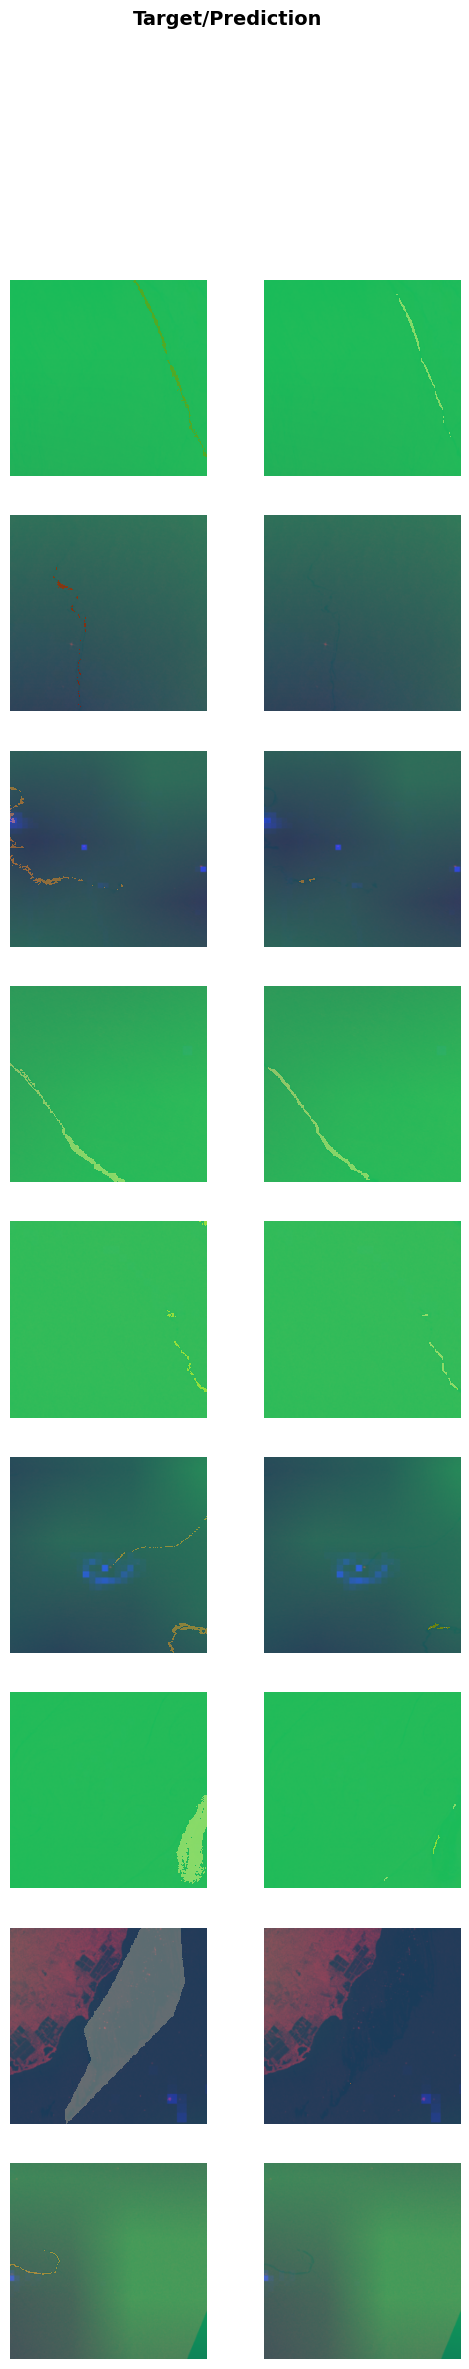

In [10]:
print("starting from running total", running_total_epochs)
print("size", size)
print("batch size", bs)
print("arch", arch)
print("lr", lr)
print("n chips", n)
print("epochs", epochs)
print("freeze", freeze)

learner.fine_tune(epochs, lr, freeze_epochs=freeze) # cbs=cbs
learner.show_results()

running_total_epochs[size] = sum(filter(None,[running_total_epochs.get(size),epochs,freeze]))

# Progressive Resizing

In [ ]:
for size in [224]*20:
    bs = bs_d[size]
    lr = lr_d[size]

    batch_transfms = [*aug_transforms(flip_vert=True, max_rotate=180, max_warp=0.1, size=size)]
    coco_seg_dblock = DataBlock(
            blocks=(ImageBlock, MaskBlock(codes=class_ints)), # ImageBlock is RGB by default, uses PIL
            get_x=get_image_by_record_id,
            splitter=IndexSplitter(val_indices),
            get_y=get_mask_by_record_id,
            batch_tfms=batch_transfms,
            item_tfms = Resize(size),
            n_inp=1
        )
    learner.dls = coco_seg_dblock.dataloaders(source=train_val_record_ids, batch_size=bs)
    print("starting from running total", running_total_epochs)
    print("image size", size)
    print("batch size", bs)
    print("arch", arch)
    print("lr", lr)
    print("n chips", n)
    print("epochs", epochs)
    print("freeze", freeze)

    learner.fine_tune(epochs, lr, freeze_epochs=freeze) # cbs=cbs
    learner.show_results()

    running_total_epochs[size] = sum(filter(None,[running_total_epochs.get(size),epochs,freeze]))
    checkpoint = learner

starting from running total {224: 1}
image size 224
batch size 32
arch 34
lr 0.003
n chips all
epochs 1
freeze 0


epoch,train_loss,valid_loss,dice_multi,dice,time
0,0.129684,0.089692,0.141538,0.000000,01:48


starting from running total {224: 2}
image size 224
batch size 32
arch 34
lr 0.003
n chips all
epochs 1
freeze 0


epoch,train_loss,valid_loss,dice_multi,dice,time
0,0.122638,0.082845,0.141538,0.000000,01:50


starting from running total {224: 3}
image size 224
batch size 32
arch 34
lr 0.003
n chips all
epochs 1
freeze 0


epoch,train_loss,valid_loss,dice_multi,dice,time
0,0.113749,0.079326,0.158474,0.367803,01:50


starting from running total {224: 4}
image size 224
batch size 32
arch 34
lr 0.003
n chips all
epochs 1
freeze 0


epoch,train_loss,valid_loss,dice_multi,dice,time


# Model Inference and Result Evaluation

In [40]:
with learner.no_bar():
    val_arrs = []
    class_preds = []
    for batch_tuple in dls.train:
        for img, val_mask in zip(batch_tuple[0], batch_tuple[1]):
            semantic_mask = val_mask.cpu().detach().numpy()
            class_pred = learner.predict(img.cpu())
            class_pred = class_pred[0].cpu().detach().numpy()
            val_arrs.append(semantic_mask)
            class_preds.append(class_pred)
            break

# inspecting preds

In [77]:
b = next(iter(dls.train))
val_mask  = b[1][0]
semantic_mask = val_mask.cpu().detach().numpy()
img  = b[0][0]

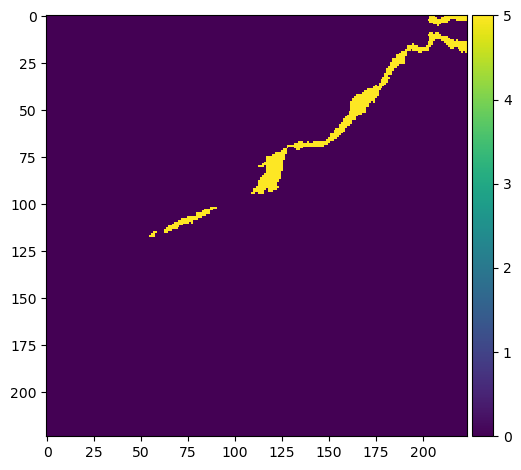

In [78]:
import skimage.io as skio
skio.imshow(semantic_mask)

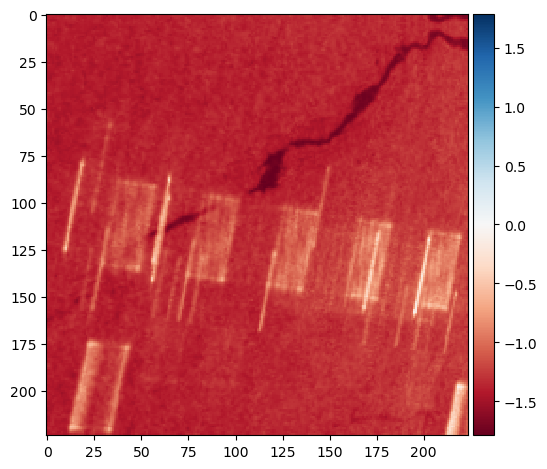

In [79]:
skio.imshow(np.moveaxis(img.cpu().detach().numpy(), 0, 2)[:,:,0])

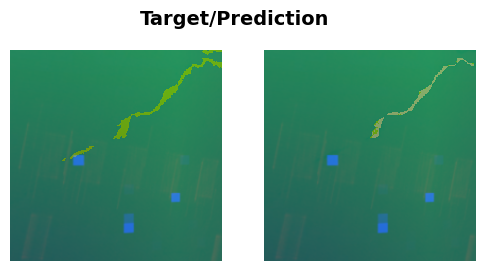

In [80]:
_,_,preds=learner.get_preds(dl=[b], with_decoded=True)
dls.show_results(b, preds, max_n=1)

In [115]:
learner.predict??

Signature: learner.predict(item, rm_type_tfms=None, with_input=False)
Docstring: Prediction on `item`, fully decoded, loss function decoded and probabilities
Source:   
    def predict(self, item, rm_type_tfms=None, with_input=False):
        dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        i = getattr(self.dls, 'n_inp', -1)
        inp = (inp,) if i==1 else tuplify(inp)
        dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
        dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
        res = dec_targ,dec_preds[0],preds[0]
        if with_input: res = (dec_inp,) + res
        return res
File:      ~/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/learner.py
Type:      method


In [81]:
outputs = learner.predict(img.cpu())

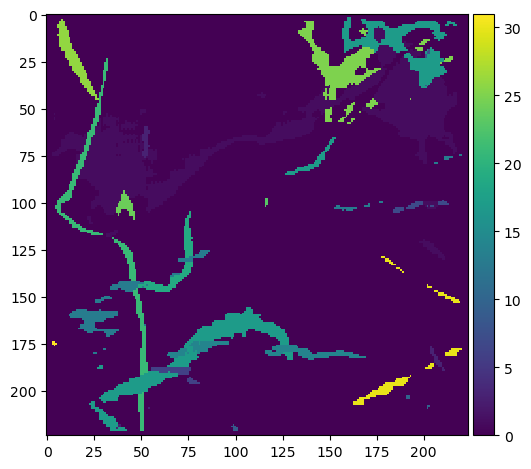

In [92]:
skio.imshow(np.argmax(preds.cpu().detach().numpy(), axis=0))

In [99]:
from ceruleanml.inference import save_fastai_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes
save_template = f'test_{bs}_{arch}_{size}_{round(validation[1],3)}_{epochs}.pt'
state_dict_pth, tracing_model_gpu_pth, tracing_model_cpu_pth  = save_fastai_model_state_dict_and_tracing(learner, dls, save_template, experiment_dir)

/root/experiments/cv2/08_Jul_2022_20_26_13_fastai_unet/tracing_gpu_test_32_34_224_0.236_10.pt
/root/experiments/cv2/08_Jul_2022_20_26_13_fastai_unet/tracing_cpu_test_32_34_224_0.236_10.pt
/root/experiments/cv2/08_Jul_2022_20_26_13_fastai_unet/state_dict_test_32_34_224_0.236_10.pt


In [134]:
type(b[0].cpu().detach().numpy())

numpy.ndarray

In [132]:
b[0].shape

torch.Size([32, 3, 224, 224])

In [106]:
b[0].shape

torch.Size([32, 3, 224, 224])

In [139]:
b[0].cpu().detach().numpy().shape

(32, 3, 224, 224)

In [140]:
type(b[0].cpu().detach().numpy())

numpy.ndarray

After loading numpy array batch with the shape above, import Torch and call torch.Tensor on the numpy array batch of tiles

In [136]:
model = torch.load(tracing_model_cpu_pth)
#these are equivalent
# inference on a tensor
# b_result = model(b[0].cpu())

# inference on numpy array converted to tensor
b_result = model(torch.Tensor(b[0].cpu().detach().numpy())) 

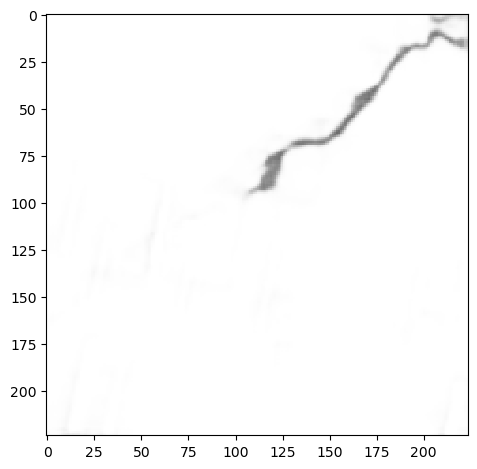

In [141]:
skio.imshow(b_result[0].sigmoid().detach().numpy()[0])

In [142]:
b_result.shape

torch.Size([32, 7, 224, 224])

In [147]:
#argmax to get category index where confidence is highest
# confidence is returned after applying sigmoid to the logits
# we only apply sigmoid on an individual tile from the batch!
tile = b_result[0,:,:,:]
indices = np.argmax(tile.sigmoid().cpu().detach().numpy(), axis=0)

In [182]:
conf_thresh=.3

In [183]:
cpu_tile_confs= tile.sigmoid().cpu().detach().numpy()

In [184]:
high_conf_mask = np.any(np.where(cpu_tile_confs> conf_thresh, 1, 0), axis=0)

In [185]:
np.unique(high_conf_mask)

array([ True])

In [186]:
np.unique(indices)

array([0, 4, 5])

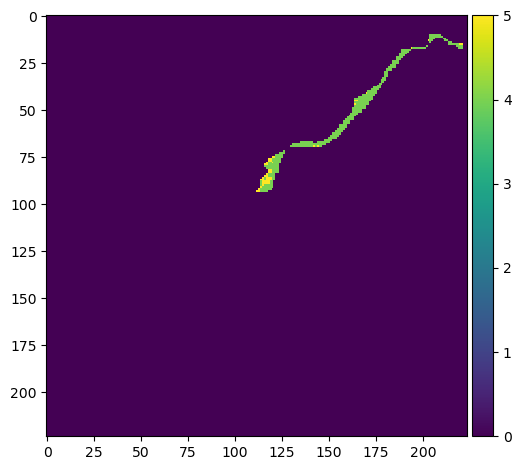

In [187]:
skio.imshow(np.where(high_conf_mask, indices, 0))

# CM is bugged because predict is bugged

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/metrics.py:370: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


Confusion matrix saved at /root//cm_count.png
f1_score 0.1415375788717925


(array([[13102505,    60809,     6299,    33494,    29444,    52697],
        [      26,        0,        0,        0,        0,        0],
        [       0,        0,        0,        0,        0,        0],
        [       0,        0,        0,        0,        0,        0],
        [       0,        0,        0,        0,        0,        0],
        [       0,        0,        0,        0,        0,        0]]),
 0.1415375788717925)

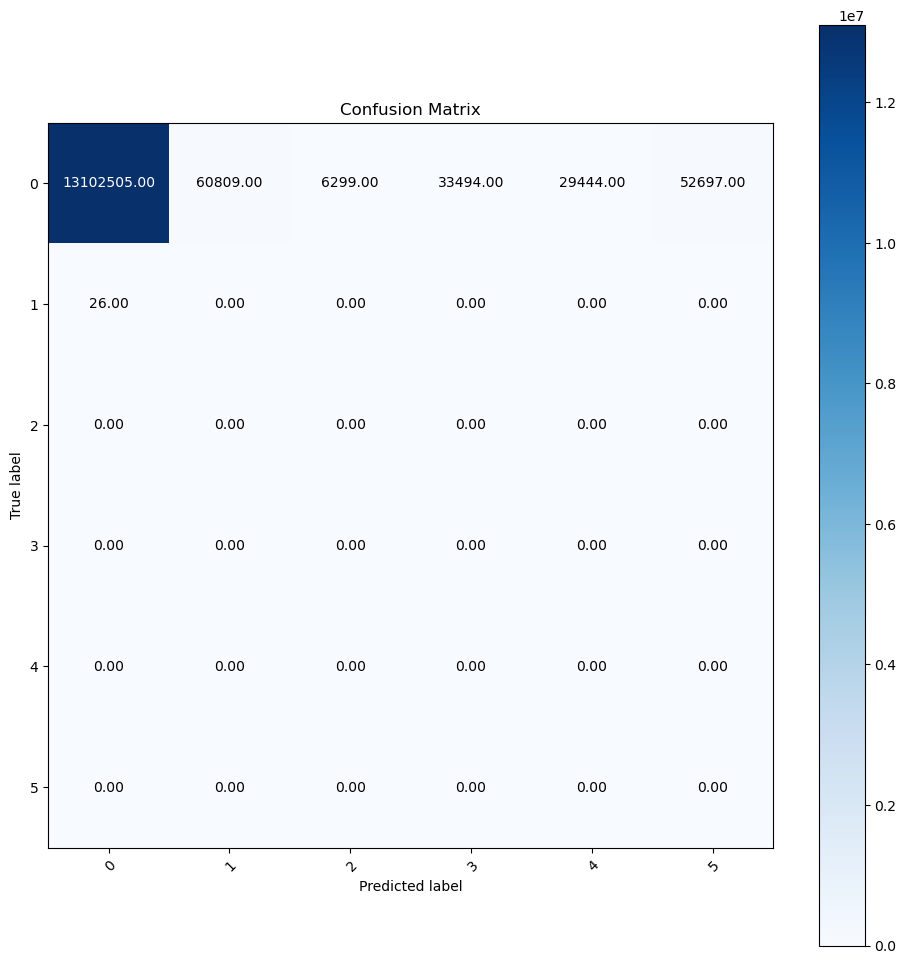

In [12]:
evaluation.get_cm_for_learner(dls, learner, mount_path)

In [94]:
validation = learner.validate()

# We save the best model in a variety of formats for loading later. Eval on Torchscript model still being debugged

In [97]:
save_template = f'test_{bs}_{arch}_{size}_{round(validation[1],3)}_{epochs}.pt'

In [173]:
from ceruleanml.inference import save_fastai_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes

state_dict_pth, tracing_model_gpu_pth, tracing_model_cpu_pth  = save_fastai_model_state_dict_and_tracing(learner, dls, save_template, experiment_dir)

model = torch.load(tracing_model_cpu_pth)

In [ ]:
def get_cm_for_torchscript_model(dls, model, save_path):
"""
the torchscript model when it is loaded operates on batches, not individual images
this doesn't support eval on negative samples if they are in the dls, 
since val masks don't exist with neg samples. need to be constructed with np.zeros

returns cm and f1 score
"""
val_arrs = []
class_preds = []
for batch_tuple in dls.valid:
    semantic_masks_batch = batch_tuple[1].cpu().detach().numpy()
    class_pred_batch = model(batch_tuple[0].cpu())
    class_pred_batch = class_pred_batch.cpu().detach().numpy()
    val_arrs.extend(semantic_masks_batch)
    class_preds.append(class_pred_batch)
return evaluation.cm_f1(val_arrs, class_preds, 6, save_path) # todo add normalize false

In [ ]:
get_cm_for_torchscript_model(dls, model, mount_path)

In [ ]:
# this results in vm dying, not just kernel crash
# coco_seg_dblock = DataBlock(
#     blocks=(ImageBlock, MaskBlock(codes=class_ints)),
#     get_x=get_image_by_record_id,
#     get_y=get_mask_by_record_id,
#     n_inp=1,
# )

# dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=5)


In [ ]:
result = learner.get_preds(dl=dls[0])

In [ ]:
learner.get_preds??

In [ ]:
len(pred_arrs)

In [ ]:
target_label,prediction_arr, activations = pred_arrs[0]

In [ ]:
skio.imshow(target_label.cpu().detach().numpy())

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[0])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy())

In [ ]:
array([      60.73,       190.3,      4.3598]) # means
array([     16.099,      17.846,       9.603]) # stats